In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.spatial import distance_matrix as distanceMatrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

In [2]:
def loadData(path):
    data = pd.read_csv(path)
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return x, y

def splitData(x, y, train_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0, stratify=y)
    return x_train, x_test, y_train, y_test

def preprocessData(x):

    # Creating instance of one-hot-encoder    
    one_hot_scaler = OneHotEncoder()

    # Only for categorical data which are at columns in index 1,2,3
    encoded = one_hot_scaler.fit_transform(x[:, [1,2,3]]).toarray()

    # Adding the encoded columns to the original data
    x = np.concatenate((x, encoded), axis=1)
    
    # Dropping the categorical columns
    x = np.delete(x, [1,2,3], axis=1)

    # Scaling the data since the features are in different scales
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    x = pd.DataFrame(scaler.transform(x))
    
    return x

### Hierarchical Clustering (Agglomerative Clustering not Divisive)

In [3]:
def linkage(distance_matrix, clusters, cluster1, cluster2, linkage):
    if linkage == 'single': # Minimum distance between two clusters
        min_distance = np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] < min_distance:
                    min_distance = distance_matrix[i,j]
        return min_distance
    elif linkage == 'complete': # Maximum distance between two clusters
        max_distance = -np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] > max_distance:
                    max_distance = distance_matrix[i,j]
        return max_distance
    elif linkage == 'average' or linkage == 'centroid' or linkage == 'mean': # Average distance between two clusters
        sum_distance = 0
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                sum_distance += distance_matrix[i,j]
        return sum_distance/(len(clusters[cluster2]) * len(clusters[cluster1]))
    else:
        raise ValueError('Invalid linkage type')
    
def hierarchical_clustering(data, linkage_type, n_clusters, y):
    # Marking each data point as a cluster
    clusters = [[i] for i in range(len(data))]

    # Calculating the distance matrix using Euclidean distance (default of distanceMatrix function)
    distance_matrix = distanceMatrix(data, data)

    # Iteratively merging the clusters
    while len(clusters) > n_clusters:

        # Finding closest two clusters
        min_distance = np.inf
        min_i,min_j = -1,-1
        for i in range(len(clusters)):
            for j in range(i+1,len(clusters)):
                dist = distance_matrix[i,j]
                if dist < min_distance:
                    min_distance = dist
                    min_i,min_j = i,j

        # Merging the closest two clusters
        clusters[min_i] = clusters[min_i] + clusters[min_j]

        # Removing the second cluster
        clusters.pop(min_j)
        
        # Adjusting the distance matrix 
        for i in range(len(clusters)):
            if i == min_i: continue
            distance_matrix[min_i,i] = distance_matrix[i,min_i] = linkage(distance_matrix, clusters, i, min_i, linkage_type)
    
    # Using the majority voting to get the cluster labels 
    indexToLabel = {}
    for i in range(len(clusters)):
        labels = []
        for j in clusters[i]:
            labels.append(y[j])
        indexToLabel[i] = max(set(labels), key = labels.count)
        
    predicted = []
    for i in range(len(data)):
        for j in range(len(clusters)):
            if i in clusters[j]:
                predicted.append(indexToLabel[j])
                break
    return clusters, predicted

# Evaluating hierarchical clustering

In [4]:
# Loading the data
x, y = loadData('archive/kddcup.data_10_percent_corrected')

# Splitting the data into train and test
x_train, x_test, y_train, y_test = splitData(x, y, train_size=0.0025)

# Only using the training data, which will be preprocessed
x_train = preprocessData(x_train)
print("The shape of the training data is: ", x_train.shape)

The shape of the training data is:  (1235, 71)


In [5]:
# Applying hierarchical clustering
clusters, clusters_labels = hierarchical_clustering(x_train, 'single', 23, y_train)
y_pred = clusters_labels
total_prec = 0
total_rec = 0
f1 = 0

for i in range(len(clusters)):
    total_prec += np.sum(y_pred[i] == y_train[clusters[i]]) / len(clusters[i])
    total_rec += np.sum(y_pred[i] == y_train[clusters[i]]) / len(y_train[clusters[i]])

f1 = 2 * (total_prec/len(clusters) * total_rec/len(clusters)) / (total_prec/len(clusters) + total_rec/len(clusters))

print("The average precision(purity) is: ", total_prec/len(clusters))
print("The average recall is: ", total_rec/len(clusters))
print("The average f1 score is: ", f1)

print("-" * 50)

print("Precision: ", precision_score(y_train, y_pred, average='macro'))
print("Recall: ", recall_score(y_train, y_pred, average='macro'))
print("F1 score: ", f1_score(y_train, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_train, y_pred))


The average precision(purity) is:  0.6334635650023298
The average recall is:  0.6334635650023298
The average f1 score is:  0.6334635650023298
--------------------------------------------------
Precision:  0.23395721925133686
Recall:  0.0947102311115578
F1 score:  0.07366185842614101
Accuracy:  0.5773279352226721


C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
y_pred = np.array(y_pred)
print(y_pred.shape)
print(y_train.shape)

(1235,)
(1235,)


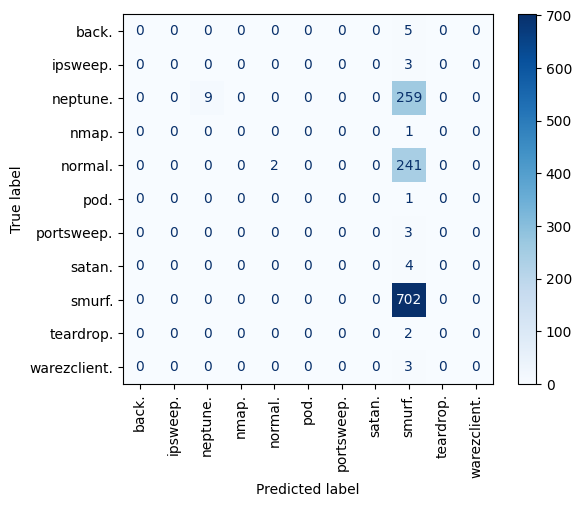

In [7]:
# print the confusion matrix
cm = confusion_matrix(y_train, y_pred)
# Display the confusion matrix in much bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.show()


In [8]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       back.       0.00      0.00      0.00         5
    ipsweep.       0.00      0.00      0.00         3
    neptune.       1.00      0.03      0.06       268
       nmap.       0.00      0.00      0.00         1
     normal.       1.00      0.01      0.02       243
        pod.       0.00      0.00      0.00         1
  portsweep.       0.00      0.00      0.00         3
      satan.       0.00      0.00      0.00         4
      smurf.       0.57      1.00      0.73       702
   teardrop.       0.00      0.00      0.00         2
warezclient.       0.00      0.00      0.00         3

    accuracy                           0.58      1235
   macro avg       0.23      0.09      0.07      1235
weighted avg       0.74      0.58      0.43      1235



C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1